## Covid-19 Hospitalizations Analytics

The covid-19 virus affects each person in different ways: some may be infected and never knows (asymptomatic), others have flu symptoms in different degrees, and several, evolve into serious health issues that demand hospitalizations.

The objective of this mini-project is to understand who are those from the third group. What are their characteristics like gender, ethnicity, schooling, and so on.

For this task, we will use some R libraries namely: Tidyverse (data structures), Ggrepel (text and label geoms), and Wesanderson (color palette).

In [ ]:
# Load necessary libraries
library(tidyverse)
library(ggrepel)
library(wesanderson)

### Dataset

The data originates from the Brazilian Ministry of Health website that since 2009 started to record SARS cases which incurred in hospitalizations ([source](https://shiny.hmg.saude.gov.br/dataset/bd-srag-2020)).

In [ ]:
# Load dataset from CSV file
data <- read.csv("sars.csv", header = TRUE)


Before start, it is always a good idea to get acquainted with the dataset.

In [ ]:
# Print the first six rows of the dataset with its headers
head(data); sprintf("% s rows x % s columns", nrow(data),  ncol(data))

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,⋯,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA
,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,07/02/2020,6,21/01/2020,4,MG,BELO HORIZONTE,1449,BELO HORIZONTE,310620,HOSPITAL RISOLETA TOLENTINO NEVES,⋯,,NA,,,NA,,,NA,NA,NA
2,24/01/2020,4,22/01/2020,4,AM,ENTORNO DE MANAUS E RIO NEGRO,5584,MANAUS,130260,HOSPITAL E P S DA CRIANCA DA ZONA OESTE,⋯,,NA,,,NA,,,NA,NA,NA
3,29/02/2020,9,22/02/2020,8,MA,REGI0NAL DE SAUDE METROPOLITANA,1430,SAO LUIS,211130,HOSPITAL SAO DOMINGOS,⋯,,NA,,,NA,,,NA,NA,NA
4,28/02/2020,9,25/02/2020,9,AM,ENTORNO DE MANAUS E RIO NEGRO,5584,MANAUS,130260,HOSPITAL E PRONTO SOCORRO DA ZONA NORTE DELPHINA AZIZ,⋯,,NA,,,NA,,,NA,NA,NA
5,15/03/2020,12,11/03/2020,11,ES,COLATINA,1509,COLATINA,320150,HOSPITAL E MATERNIDADE SILVIO AVIDOS,⋯,,NA,,,NA,,,NA,NA,NA
6,20/03/2020,12,18/03/2020,12,SP,GVE I CAPITAL,1331,SAO PAULO,355030,HC DA FMUSP HOSPITAL DAS CLINICAS SAO PAULO,⋯,,NA,,,NA,,,NA,NA,NA


[1] "2446090 rows x 154 columns"

As we can check, the dataset contains 2,446,090 observations (rows) and 154 variables (columns). From those variables, we select the most relevant for this analysis.

In [ ]:
# Reduce the number of variables (columns) 
names <- c('DT_SIN_PRI','SEM_PRI', 'SG_UF_NOT', 'ID_MUNICIP','CS_SEXO','NU_IDADE_N','CS_GESTANT','CS_RACA','CS_ESCOL_N','HISTO_VGM','FATOR_RISC','VACINA','UTI','CLASSI_FIN','EVOLUCAO')
df <- subset(data, select = names)

# Print the first six rows of the dataset with its headers
head(df); sprintf("% s rows x % s columns", nrow(df),  ncol(df))

,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_MUNICIP,CS_SEXO,NU_IDADE_N,CS_GESTANT,CS_RACA,CS_ESCOL_N,HISTO_VGM,FATOR_RISC,VACINA,UTI,CLASSI_FIN,EVOLUCAO
,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,21/01/2020,4,MG,BELO HORIZONTE,M,25,6,4,9,0,N,9,2,4,NA
2,22/01/2020,4,AM,MANAUS,M,13,6,4,NA,0,S,2,1,2,1
3,22/02/2020,8,MA,SAO LUIS,M,15,6,4,3,2,N,NA,2,1,1
4,25/02/2020,9,AM,MANAUS,M,1,6,4,5,2,N,1,2,4,1
5,11/03/2020,11,ES,COLATINA,M,3,6,1,NA,2,N,1,NA,4,1
6,18/03/2020,12,SP,SAO PAULO,M,9,6,1,9,0,S,1,2,4,1


[1] "2446090 rows x 15 columns"

### Metadata

These are the selected variables and their description:

* DT_SIN_PRI: date of case first symptoms.
* SEM_PRI: epidemiological week of the first symptoms.
* SG_UF_NOT: federative state of the notification.
* ID_MUNICIP: municipality of the notification.
* CS_SEXO: gender (1: male, 2: female, 9: ignored).
* NU_IDADE_N: age.
* CS_GESTANT: pregnancy (1: first quarter, 2: second quarter, 3: third quarter, 4: ignored gestational age, 5: absent, 6: not applicable, 9: ignored).
* CS_RACA: ethnicity (1: white, 2: black, 3: asian, 4: mixed, 5: indigenous,  9: ignored).
* CS_ESCOL_N: schooling (0: no schooling, 1: fundamental (first cycle), 2: fundamental (second cycle), 3: high school, 4: university, 5: not applicable, 9: ignored).
* HISTO_VGM: international travel (0: yes, 2: no, 9: ignored).
* FATOR_RISC: patient with risk factor (1: yes, 2: no, 9: ignored).
* VACINA: previous flu vaccine (1: yes, 2: no, 9: ignored).
* UTI: received intensive care  (1: yes, 2: no, 9: ignored).
* CLASSI_FIN: SARS classification (1: influenza, 2: another respiratory virus, 3: another etiologic agent, 4: not-specified, 5: COVID-19).
* EVOLUCAO: case evolution (1: recovered, 2: deceased, 3: deceased for another cause, 9: ignored).

### Data wrangling

At first glance, the *date* variable needs to be converted to the proper format.

In [ ]:
# Transform column to dateTime format
df$DT_SIN_PRI <- as.Date(df$DT_SIN_PRI, "%d/%m/%Y")

In [ ]:
# Get the descriptive statistics
summary(df)

   DT_SIN_PRI            SEM_PRI       SG_UF_NOT          ID_MUNICIP       
 Min.   :2019-12-29   Min.   : 1.00   Length:2446090     Length:2446090    
 1st Qu.:2020-05-21   1st Qu.:21.00   Class :character   Class :character  
 Median :2020-07-10   Median :28.00   Mode  :character   Mode  :character  
 Mean   :2020-07-20   Mean   :29.77                                        
 3rd Qu.:2020-09-12   3rd Qu.:37.00                                        
 Max.   :2021-01-03   Max.   :53.00                                        
                                                                           
   CS_SEXO            NU_IDADE_N       CS_GESTANT       CS_RACA      
 Length:2446090     Min.   : -3.00   Min.   :0.000   Min.   :1.00    
 Class :character   1st Qu.: 43.00   1st Qu.:5.000   1st Qu.:1.00    
 Mode  :character   Median : 60.00   Median :6.000   Median :4.00    
                    Mean   : 56.86   Mean   :5.812   Mean   :3.56    
                    3rd Qu.: 74.00   3rd Q

Now we need to handle the missing values (NAs). For that, we will impute the value 9 (= ignored) to be concise with the original annotation.

In [ ]:
# Impute the 'ignored' value for NAs on each column
df <- mutate(df,across(where(is.numeric),function(xx) ifelse(is.na(xx),9,xx)))

From the previous summary, we can check some issues with the ages. The minimum is -3 and the maximum is 148. Let's fix it.

In [ ]:
# Impute zero years old for negative values
df$NU_IDADE_N[df$NU_IDADE_N < 0] <- 0

# Impute 120 years old for greater than 120
df$NU_IDADE_N[df$NU_IDADE_N > 120] <- 120

Looking closer, there are issues also with the *pregnancy* and *international travel* variables. The first cannot have 0s and the latter 1s. So again, we will input the value 9 (= ignored).

In [ ]:
# Impute the 'ignored' value for 0s on CS_GESTANT	column
df$CS_GESTANT[which(df$CS_GESTANT==0)] <- 9

# Impute the 'ignored' value for 1s on CS_HISTO_VGM	column
df$HISTO_VGM[which(df$HISTO_VGM==1)] <- 9

In [ ]:
# Check the result
summary(df)

   DT_SIN_PRI            SEM_PRI       SG_UF_NOT          ID_MUNICIP       
 Min.   :2019-12-29   Min.   : 1.00   Length:2446090     Length:2446090    
 1st Qu.:2020-05-21   1st Qu.:21.00   Class :character   Class :character  
 Median :2020-07-10   Median :28.00   Mode  :character   Mode  :character  
 Mean   :2020-07-20   Mean   :29.77                                        
 3rd Qu.:2020-09-12   3rd Qu.:37.00                                        
 Max.   :2021-01-03   Max.   :53.00                                        
   CS_SEXO            NU_IDADE_N       CS_GESTANT       CS_RACA     
 Length:2446090     Min.   :  0.00   Min.   :1.000   Min.   :1.000  
 Class :character   1st Qu.: 43.00   1st Qu.:5.000   1st Qu.:1.000  
 Mode  :character   Median : 60.00   Median :6.000   Median :4.000  
                    Mean   : 56.86   Mean   :5.814   Mean   :3.952  
                    3rd Qu.: 74.00   3rd Qu.:6.000   3rd Qu.:4.000  
                    Max.   :120.00   Max.   :9.000   M

Since we are interested only in the Covid-19 cases, let's create a logical variable to identify them.

In [ ]:
# Create a new column for COVID-19 cases
df <- df %>% mutate(IS_COVID=ifelse(CLASSI_FIN == 5,T,F))

Finally, we will segregate the Covid-19 cases and create an exclusive dataset.

In [ ]:
# Create a new dataset with only COVID-19 cases
ds <- filter(df, IS_COVID)

### Plotting

Time for visualizations. Let's create a pie chart to check the distribution of gender.

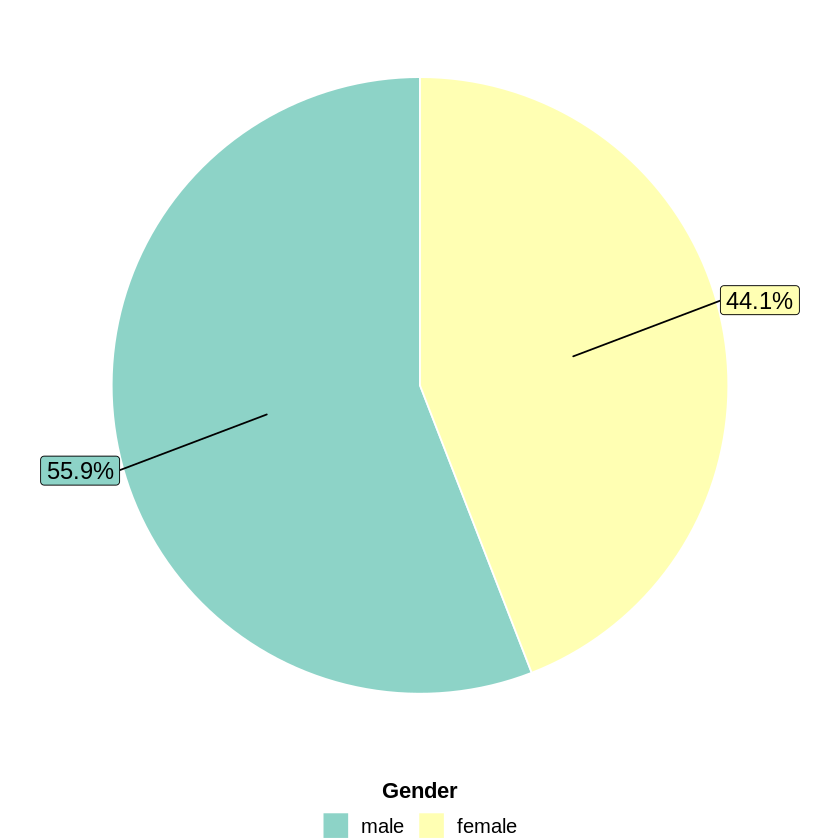

In [ ]:
# Create a table with aggregated data
tb <- ds %>% 
group_by(CS_SEXO) %>% 
count() %>% 
ungroup() %>% 
mutate(per=round(n/sum(n)*100,1)) %>% 
mutate(lab = c("female","ignored","male")) %>% 
arrange(desc(n)) %>%
mutate(cs = rev(cumsum(rev(per))), pos = per/2 + lead(cs, 1), pos = if_else(is.na(pos), per/2, pos)) %>% 
subset(per >=0.1) # select factors equal or above 0.1%

# Plot the pie chart
ggplot(tb, aes(x = "" , y = per, fill = fct_inorder(lab))) +
  geom_col(width = 1,color="white") +
  coord_polar(theta = "y", start = 0 ) +
  scale_fill_brewer(palette = "Set3", direction = -4) +
  geom_label_repel(aes(y = pos, label = paste0(per, "%")), data = tb, size=5, show.legend = F, nudge_x = 1) +
  guides(fill = guide_legend(title = "Gender", title.position="top", title.hjust = 0.5 ))+
  theme_void()+ theme(legend.title = element_text(size=rel(1.2), face="bold"),legend.text=element_text(size=rel(1.1)),legend.position="bottom") 

The pie chart shows that the majority of patients are male.

Maybe it's a good idea to have a function to plot the pie chart depending on the variable we want to check. Let's do that.

In [ ]:
# Create a plot function (pie chart)
pie_chart <- function(df, feat) {

  if (feat == "FATOR_RISC") {
      dic <- data.frame(row.names=str_sort(str_replace_all(c(as.character(unique(df$FATOR_RISC))),c("N" = "no", "S" = "yes")),numeric=F),
                       val=str_sort(c(as.character(unique(df$FATOR_RISC))),numeric=F))
      name <- "Risk Factor"
  } else if (feat == "CS_SEXO") {
      dic <- data.frame(row.names=str_sort(str_replace_all(c(as.character(unique(df$CS_SEXO))),c("M" = "male", "F" = "female", "I" = "ignored")),numeric=F),
                       val=str_sort(c(as.character(unique(df$CS_SEXO))),numeric=F))
      name <- "Gender"
  } else if (feat == "CS_RACA") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$CS_RACA))),numeric=F)),c("1" = "white", "2" = "black", "3"= "asian","4"="mixed","5"="indigenous","9"="ignored")),
                        val=sort(unique(df$CS_RACA)))
      name <- "Ethnicity"
  } else if (feat == "CS_ESCOL_N") { 
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$CS_ESCOL_N))),numeric=F)),c("0" = "no schooling", "1" = "fund.(1st cycle)", "2" = "fund.(2nd cycle)","3"="high school","4"="university","5"="not applicable","9"="ignored")), 
                        val=sort(unique(df$CS_ESCOL_N)))
      name <- "Schooling"
  } else if (feat == "CS_GESTANT") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$CS_GESTANT))),numeric=F)),c("1" = "1st quarter", "2" = "2nd quarter", "3" = "3rd quarter","4"="unkown gestational age","5"="absent","6"="not applicable","9"="ignored")),
                        val=sort(unique(df$CS_GESTANT)))
      name <- "Pregnancy"
  } else if (feat == "HISTO_VGM") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$HISTO_VGM))),numeric=F)),c("0" = "yes","2" = "no", "9" = "ignored")),
                        val=sort(unique(df$HISTO_VGM)))
      name <- "International Travel"
  } else if (feat == "VACINA") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$VACINA))),numeric=F)),c("1" = "yes","2" = "no", "9" = "ignored")), 
                        val=sort(unique(df$VACINA)))
      name <- "Previously Vaccinated"
  } else if (feat == "UTI") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$UTI))),numeric=F)),c("1" = "yes","2" = "no", "9" = "ignored")), 
                        val=sort(unique(df$UTI)))
      name <- "Intensive Care"
  } else if (feat == "EVOLUCAO") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$EVOLUCAO))),numeric=F)),c("1" = "recovered","2" = "deceased","3"="deceased (other)" ,"9" = "ignored")),
                        val=sort(unique(df$EVOLUCAO)))
      name <- "Case Evolution"
  }
  

  feat <- as.symbol(feat)

  ds <- df %>% 
  group_by({{feat}}) %>% 
  count() %>% 
  ungroup() %>% 
  mutate(per=round(n/sum(n)*100,1)) %>% 
  mutate(lab = ifelse({{feat}} == dic$val, row.names(dic), {{feat}})) %>% 
  arrange(desc(n)) %>%
  mutate(cs = rev(cumsum(rev(per))), pos = per/2 + lead(cs, 1), pos = if_else(is.na(pos), per/2, pos)) %>% 
  subset(per >=0.1) # select factors equal or above 0.1%


  ggplot(ds, aes(x = "" , y = per, fill = fct_inorder(lab))) +
    geom_col(width = 1,color="white") +
    coord_polar(theta = "y", start = 0 ) +
    scale_fill_brewer(palette = "Set3", direction = -4) +
    geom_label_repel(aes(y = pos, label = paste0(per, "%")), data = ds, size=5, show.legend = F, nudge_x = 1) +
    guides(fill = guide_legend(title = name, title.position="top", title.hjust = 0.5 ))+
    theme_void()+ theme(legend.title = element_text(size=rel(1.2), face="bold"),legend.text=element_text(size=rel(1.1)),legend.position="bottom") 

}

Let's plot a new pie chart this time using the recently created function on the *ethnicity* variable.

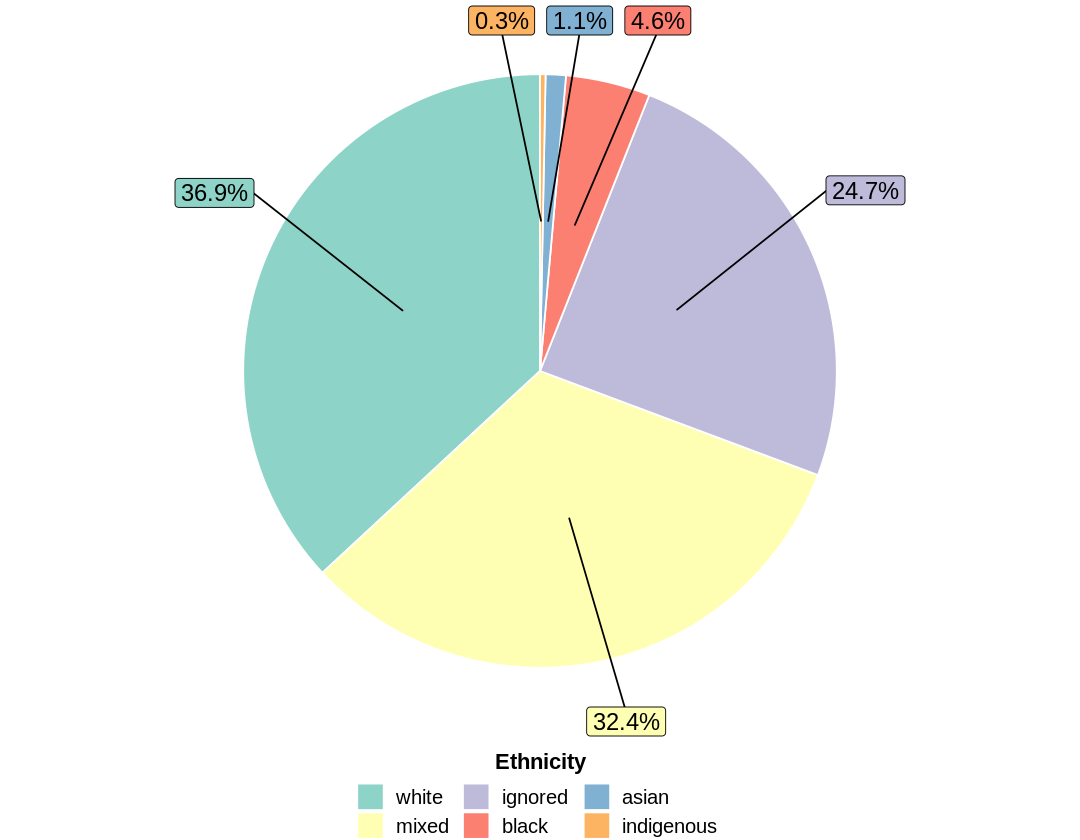

In [ ]:
# Call the function
pie_chart(ds,"CS_RACA")

From the last pie chart, we notice that *white* people compose the predominant ethnicity of the patients, followed by *mixed* people. There is also a great proportion of *ignored* ethnicity. This may be due to disclosure issues or simply the quality of the data.

Now let's create a function to plot the frequency polygon of the categorical variables against *age*.

(*for the sake of code readability, we will create a sub-function to prepare the data*)

In [ ]:
# Create a filter function
filt <- function(df,feat) {
  
  if (feat == "FATOR_RISC") {
      dic <- data.frame(row.names=str_sort(str_replace_all(c(as.character(unique(df$FATOR_RISC))),c("N" = "no", "S" = "yes")),numeric=F),
                       val=str_sort(c(as.character(unique(df$FATOR_RISC))),numeric=F))
      
  } else if (feat == "CS_SEXO") {
      dic <- data.frame(row.names=str_sort(str_replace_all(c(as.character(unique(df$CS_SEXO))),c("M" = "male", "F" = "female", "I" = "ignored")),numeric=F),
                       val=str_sort(c(as.character(unique(df$CS_SEXO))),numeric=F))
      
  } else if (feat == "CS_RACA") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$CS_RACA))),numeric=F)),c("1" = "white", "2" = "black", "3"= "asian","4"="mixed","5"="indigenous","9"="ignored")),
                        val=sort(unique(df$CS_RACA)))
      
  } else if (feat == "CS_ESCOL_N") { 
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$CS_ESCOL_N))),numeric=F)),c("0" = "no schooling", "1" = "fund.(1st cycle)", "2" = "fund.(2nd cycle)","3"="high school","4"="university","5"="not applicable","9"="ignored")), 
                        val=sort(unique(df$CS_ESCOL_N)))
      
  } else if (feat == "CS_GESTANT") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$CS_GESTANT))),numeric=F)),c("1" = "1st quarter", "2" = "2nd quarter", "3" = "3rd quarter","4"="unkown gestational age","5"="absent","6"="not applicable","9"="ignored")),
                        val=sort(unique(df$CS_GESTANT)))
      
  } else if (feat == "HISTO_VGM") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$HISTO_VGM))),numeric=F)),c("0" = "yes","2" = "no", "9" = "ignored")),
                        val=sort(unique(df$HISTO_VGM)))
      
  } else if (feat == "VACINA") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$VACINA))),numeric=F)),c("1" = "yes","2" = "no", "9" = "ignored")), 
                        val=sort(unique(df$VACINA)))
      
  } else if (feat == "UTI") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$UTI))),numeric=F)),c("1" = "yes","2" = "no", "9" = "ignored")), 
                        val=sort(unique(df$UTI)))
      
  } else if (feat == "EVOLUCAO") {
      dic <- data.frame(row.names=str_replace_all(c(str_sort(c(as.character(unique(df$EVOLUCAO))),numeric=F)),c("1" = "recovered","2" = "deceased","3"="deceased (other)" ,"9" = "ignored")),
                        val=sort(unique(df$EVOLUCAO)))
      
  }

  feat <- as.symbol(feat)
  df <- df %>% 
      group_by({{feat}}) %>% 
      count() %>% 
      ungroup() %>% 
      mutate(per=round(n/sum(n)*100,1)) %>% 
      mutate(lab = ifelse({{feat}} == dic$val, row.names(dic), {{feat}})) %>%
      subset(per >=0.5) # select factors equal or above 0.5%
  return (df)

}

In [ ]:
# Create a plot function (frequency polygon)
freq_pol <- function(df, feat) {

  if (feat == "FATOR_RISC") {
      feat <- as.symbol("FATOR_RISC");nam <-"Risk Factor"; fil <- filt(df,"FATOR_RISC")[[1]]; lab <- filt(df,"FATOR_RISC")[[4]]
      
  } else if (feat == "CS_SEXO") {
      feat <- as.symbol("CS_SEXO");nam <-"Gender"; fil <- filt(df,"CS_SEXO")[[1]]; lab <- filt(df,"CS_SEXO")[[4]]
  
  } else if (feat == "CS_RACA") {
      feat <- as.symbol("CS_RACA");nam <-"Ethnicity"; fil <- filt(df,"CS_RACA")[[1]]; lab <- filt(df,"CS_RACA")[[4]]

  } else if (feat == "CS_ESCOL_N") { 
      feat <- as.symbol("CS_ESCOL_N"); nam <-"Schooling"; fil <- filt(df,"CS_ESCOL_N")[[1]]; lab <- filt(df,"CS_ESCOL_N")[[4]]

  } else if (feat == "CS_GESTANT") {
      feat <- as.symbol("CS_GESTANT");nam <-"Pregnancy"; fil <- filt(df,"CS_GESTANT")[[1]]; lab <- filt(df,"CS_GESTANT")[[4]]

  } else if (feat == "HISTO_VGM") {
      feat <- as.symbol("HISTO_VGM");nam <-"International Travel"; fil <- filt(df,"HISTO_VGM")[[1]]; lab <- filt(df,"HISTO_VGM")[[4]]

  } else if (feat == "VACINA") {
      feat <- as.symbol("VACINA");nam <-"Previously Vaccinated"; fil <- filt(df,"VACINA")[[1]]; lab <- filt(df,"VACINA")[[4]]

  } else if (feat == "UTI") {
      feat <- as.symbol("UTI");nam <-"Intensive Care"; fil <- filt(df,"UTI")[[1]]; lab <- filt(df,"UTI")[[4]]

  } else if (feat == "EVOLUCAO") {
      feat <- as.symbol("EVOLUCAO");nam <-"Case Evolution"; fil <- filt(df,"EVOLUCAO")[[1]]; lab <- filt(df,"EVOLUCAO")[[4]]

  }
  
  options(warn = -1)
  df %>%
    filter({{feat}} == fil) %>%
    ggplot(aes(x=NU_IDADE_N, color=factor({{feat}}))) +
      geom_freqpoly(bins = 40, size = 1.3) +
      scale_x_continuous(breaks=seq(0,120,10), name = "Age") +
      scale_y_continuous(name = "Frequency") +
      theme(text = element_text(size=15), legend.title = element_text(size=rel(0.92), face="bold"),legend.text=element_text(size=rel(0.91))) +
      scale_color_manual(name=nam, labels=lab, values=wes_palette(length(lab), name = "Darjeeling1", type = "continuous"))
      
}

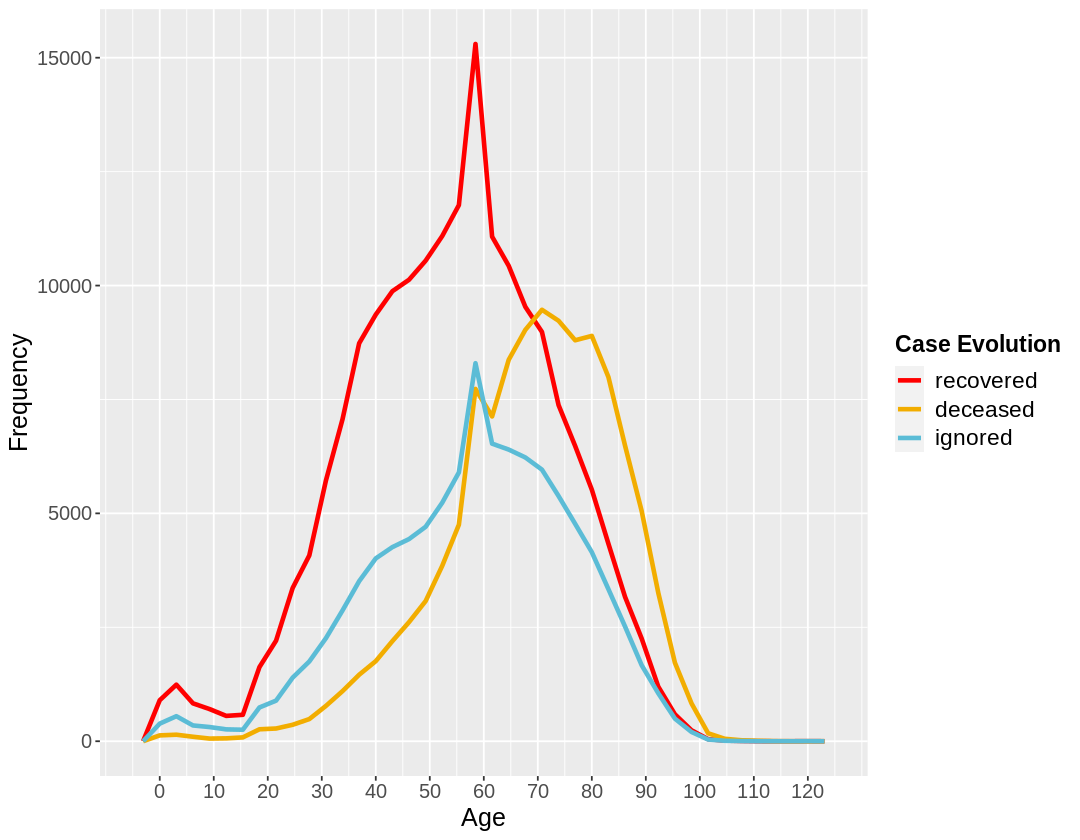

In [ ]:
options(repr.plot.width=9, repr.plot.height=7) # specify the plot's dimensions

# Call the function
freq_pol(ds,"EVOLUCAO")

As we can check the recovered patients are concentrated around the age of 55 years old while the deceased ones are older (around 70 years old).

### Conclusion

In this task, we analyzed a quite big dataset composed of patients who were hospitalized in the Brazilian Health System due to Covid-19. During the wrangling step we adjusted the type of some variables and also dealt with the missing values. Inconsistencies like negative ages were also fixed. In the end, we were able to perform some visualizations and found some interesting insights about the data like the most frequent age of recovered patients.


*P.S.: this analysis is also available via an interactive dashboard accessible [here](http://8.209.77.179/apps/covid/)*.